In [2]:
import pystan
import numpy as np
import pandas as pd
from scipy.stats import norm, beta
import matplotlib.pyplot as plt
import matplotlib as mpl
from psis import psisloo

In [3]:
# POOLED MODEL
df = pd.read_csv('factory.csv', sep=' ', header=None)
number_datapoints = df.shape[0] * df.shape[1]
# num_groups = df.shape[1]
y = df.values
y = y.ravel()
x = np.arange(1, df.shape[1]+1, 1)

In [22]:
pooled_factory_code = '''
data {
    int<lower=0> N; // number of data points
    vector[N] y;
}

parameters {
    real mu;             // prior mean
    real<lower=0> sigma;
}

model {
  y ~ normal(mu, sigma);
}

generated quantities {
    real ypred;
    vector[N] log_lik;
    
    ypred = normal_rng(mu, sigma);
    
    for (i in 1:N)
        log_lik[i] = normal_lpdf(y[i] | mu, sigma);   
}
'''


pooled_factory_data = {'N': number_datapoints,
                'y': y
               }

sm = pystan.StanModel(model_code = pooled_factory_code)
pooled_fit = sm.sampling(data = pooled_factory_data)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_678b236510469b73635a87bc71a8462c NOW.


PSIS-LOO value: -130.995070780941
The effective number of parameters is: 2.043608050711015


Text(0.5, 1.0, 'K_hat values for the pooled model')

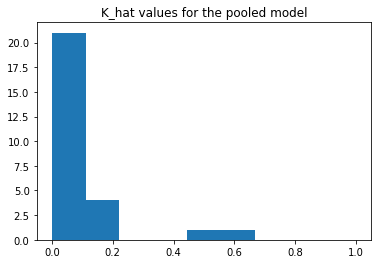

In [56]:
summary = pooled_fit.summary()
summary = pd.DataFrame(summary['summary'], columns=summary['summary_colnames'], index=summary['summary_rownames'])

log_lik = pooled_fit.extract(permuted=True)['log_lik']

loo, loos, ks = psisloo(log_lik)
print('PSIS-LOO value: {0}'.format(loo))

S = np.shape(log_lik)[0]
lppd = sum(np.log([1 / S * sum(np.exp(elem)) for elem in log_lik.T]))

p_loocv = lppd - loo
print('The effective number of parameters is: {0}'.format(p_loocv))

plt.hist(ks, bins=np.linspace(0,1,10))
plt.title('K_hat values for the pooled model')

In [48]:
# HIERARCHICAL MODEL
df = pd.read_csv('factory.csv', sep=' ', header=None)
number_datapoints = df.shape[0] * df.shape[1]
num_groups = df.shape[1]
y = df.values
y = np.reshape(y, 30, order='F')
y = y.ravel()
x = np.arange(1,7)
x = np.repeat(x, 5)

In [49]:
hierarchical_factory_code = '''
data {
    int<lower=0> N; // number of data points
    int<lower=0> K; // number of groups
    int<lower=1,upper=K> x[N]; // group indicator
    vector[N] y; //
}

parameters {
    real mu0;             // prior mean
    real<lower=0> sigma0; // prior std
    
    vector[K] mu;         // group means
    real<lower=0> sigma;
}

model {
    mu ~ normal(mu0, sigma0);
    y ~ normal(mu[x], sigma);
}

generated quantities {
    real mu7;
    real ypred6;
    vector[N] log_lik;
    
    mu7 = normal_rng(mu0, sigma0);
    ypred6 = normal_rng(mu[6], sigma);
    
    
    for (i in 1:N)
        log_lik[i] = normal_lpdf(y[i] | mu[x[i]], sigma);    
}
'''

hierarchical_factory_data = {'N': number_datapoints,
                'K': num_groups,
                'x': x,
                'y': y
               }

sm = pystan.StanModel(model_code = hierarchical_factory_code)
hierarchical_fit = sm.sampling(data = hierarchical_factory_data)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f8c3a3034182bcb6004e48af9c09d60c NOW.


PSIS-LOO value: -126.75875644970922
The effective number of parameters is: 5.6623774775509474


Text(0.5, 1.0, 'K_hat values for the hierarchical model')

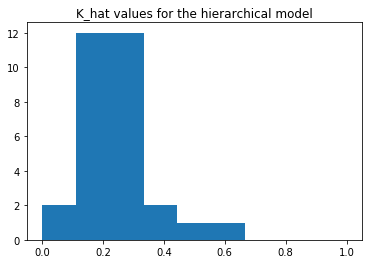

In [55]:
summary = hierarchical_fit.summary()
summary = pd.DataFrame(summary['summary'], columns=summary['summary_colnames'], index=summary['summary_rownames'])

log_lik = hierarchical_fit.extract(permuted=True)['log_lik']

loo, loos, ks = psisloo(log_lik)
print('PSIS-LOO value: {0}'.format(loo))

S = np.shape(log_lik)[0]
lppd = sum(np.log([1 / S * sum(np.exp(elem)) for elem in log_lik.T]))

p_loocv = lppd - loo
print('The effective number of parameters is: {0}'.format(p_loocv))


plt.hist(ks, bins=np.linspace(0,1,10))
plt.title('K_hat values for the hierarchical model')

In [39]:
# SEPARATE MODEL
df = pd.read_csv('factory.csv', sep=' ', header=None)
number_datapoints = df.shape[0] * df.shape[1]
num_groups = df.shape[1]
y = df.values
y = np.reshape(y, 30, order='F')
y = y.ravel()
x = np.arange(1,7)
x = np.repeat(x, 5)

print(np.unique(x))

[1 2 3 4 5 6]


In [40]:
separate_factory_code = '''
data {
    int<lower=0> N; // number of data points
    int<lower=0> K; // number of groups
    int<lower=1,upper=K> x[N]; // group indicator
    vector[N] y; //
}

parameters {
    vector[K] mu;         // group means
    vector<lower=0>[K] sigma;
}

model {
  y ~ normal(mu[x], sigma[x]);
}

generated quantities {
    real ypred;
    vector[N] log_lik;
    
    ypred = normal_rng(mu[6], sigma[6]);
    
    for (i in 1:N)
        log_lik[i] = normal_lpdf(y[i] | mu[x[i]], sigma[x[i]]);
}
'''

separate_factory_data = {'N': number_datapoints,
                'K': num_groups,
                'x': x,
                'y': y
               }

sm = pystan.StanModel(model_code = separate_factory_code)
separate_fit = sm.sampling(data = separate_factory_data)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2102e71e64cad97227419a5d38944de7 NOW.


PSIS-LOO value: -132.1335037370914
The effective number of parameters is: 9.6944760847352
(array([ 3, 14, 25]),)


Text(0.5, 1.0, 'K_hat values for the separate model')

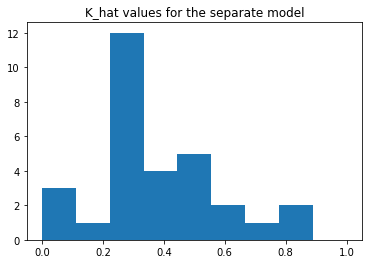

In [47]:
summary = separate_fit.summary()
summary = pd.DataFrame(summary['summary'], columns=summary['summary_colnames'], index=summary['summary_rownames'])

log_lik = separate_fit.extract(permuted=True)['log_lik']

loo, loos, ks = psisloo(log_lik)
print('PSIS-LOO value: {0}'.format(loo))

S = np.shape(log_lik)[0]
lppd = sum(np.log([1 / S * sum(np.exp(elem)) for elem in log_lik.T]))

p_loocv = lppd - loo
print('The effective number of parameters is: {0}'.format(p_loocv))

print(np.where(ks >= 0.7))

plt.hist(ks, bins=np.linspace(0,1,10))
plt.title('K_hat values for the separate model')

In [ ]:

# p_cloo_cv = lppd - loo